# Italy-Finland climate round trip with Python

This notebook demonstrates the use of Python for geospatial analysis to explore climate indexes on Italy and Finland. We'll work with climate data from the Copernicus Climate Data Store and explore patterns, trends, and anomalies.

## Libraries and Tools We'll Use
- **Xarray**: For working with multi-dimensional arrays and datasets
- **Geopandas**: For geospatial data manipulation

## 1. Setting Up Our Environment

First, let's import all the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Data acquisition
import cdsapi

import os

### What is a NetCDF file?

The Copernicus Climate Data Store provides climate data in NetCDF format (Network Common Data Form – .nc extension). It is a data format specifically designed for storing multidimensional scientific data. These files are particularly common in climate science, meteorology, oceanography, and other geosciences. 

The Copernicus data we are using contains gridded temperature observations across Europe, it represents temperature values across different geographical coordinates (latitude, longitude) and time periods.

Key features of NetCDF (.nc) files include:

- Self-describing format - The file contains metadata about the variables, dimensions, units, and other attributes, making it self-documenting.
- Machine-independent - NetCDF files can be accessed across different computing platforms.
- Direct access - You can access a subset of data without reading the entire file.
- Supports arrays - Designed to efficiently store and retrieve multidimensional arrays of data.
- Append-able - New data can be added to an existing NetCDF file without rewriting it.

## 3. Load and Explore the Climate Data with Xarray

Xarray is perfect for climate data because it handles multi-dimensional datasets with labeled coordinates and metadata.

In [12]:
# Retrieve data from Copernicus
def get_copernicus_data(output_file='copernicus_temperatures.nc'):

    if os.path.exists(output_file):
        print(f"File {output_file} already exists. Using cached version.")
        return output_file
        
    dataset = "insitu-gridded-observations-europe"
    request = {
        "product_type": "ensemble_mean",
        "variable": ["mean_temperature"],
        "grid_resolution": "0_25deg",
        "period": "full_period",
        "version": ["30_0e"]
    }
    
    print("Downloading data from Copernicus...")
    client = cdsapi.Client()
    client.retrieve(dataset, request).download()
    print(f"Data downloaded successfully to {output_file}")
    return output_file

In [ ]:
temperature_file = get_copernicus_data()

In [10]:
# Load the netCDF file using xarray
ds = xr.open_dataset('./copernicus_temperatures.nc')

print("Dataset Overview:")
print(ds)

print("\nVariables:")
for var_name in ds.variables:
    var = ds[var_name]
    print(f"{var_name}: {var.dims} - {var.shape}")

print(f"\nTime period: {ds.time[0].values} to {ds.time[-1].values}")

Dataset Overview:
<xarray.Dataset> Size: 10GB
Dimensions:    (latitude: 201, longitude: 464, time: 27210)
Coordinates:
  * latitude   (latitude) float64 2kB 25.38 25.62 25.88 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 4kB -40.38 -40.12 -39.88 ... 75.12 75.38
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    tg         (time, latitude, longitude) float32 10GB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:35:42 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

Variables:
latitude: ('latitude',) - (201,)
longitude: ('longitude',) - (464,)
tg: ('time', 'latitude', 'longitude') - (27210, 201, 464)
time: ('time',) - (27210,)

Time period: 1950-01-01T00:00:00.000000000 to 2024-06-30T00:00:00.000000000


## 4. Prepare Geographic Boundaries for Italy and Finland

Using Geopandas, we'll load the country boundaries to focus our analysis on these two European countries.

### Coordinate reference system and projections

The copernicus data uses geographic coordinates (latitude/longitude in degrees) epsg=4326.

Which CRS is best for our case? For Finland is EPSG:3879. Italy is EPSG:32633 or EPSG:32632?

But these are in a projected coordinate system (EPSG:32633, which is UTM zone 33N in meters): no data is being extracted when I try to filter using these incompatible coordinate systems.


TALK: Let's explain in our talk what is it and why it is important. Show maps at different projections.

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


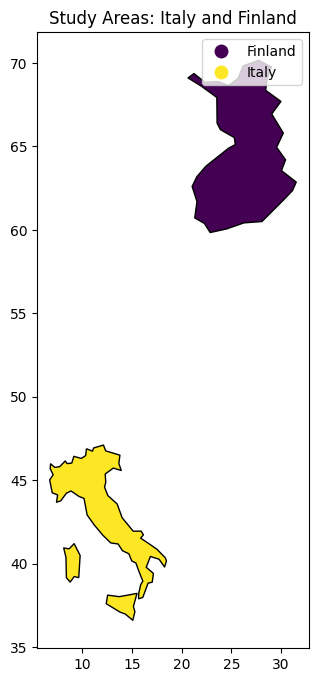

Italy bounds: [ 6.74995528 36.61998729 18.48024702 47.11539317]
Finland bounds: [20.64559289 59.8463732  31.51609216 70.16419302]


In [42]:
# Download Natural Earth data directly
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
print(world.columns)

# Extract Italy and Finland 
countries = world[world['NAME'].isin(['Italy', 'Finland'])]
countries = countries.to_crs(epsg=4326) # set the coordinate reference system

# Create a plot of our countries
fig, ax = plt.subplots(figsize=(12, 8))
countries.plot(ax=ax, column='NAME', categorical=True, legend=True, 
               cmap='viridis', edgecolor='black')
ax.set_title('Study Areas: Italy and Finland')
plt.show()

# Get bounding boxes for each country
italy = countries[countries['NAME'] == 'Italy']
finland = countries[countries['NAME'] == 'Finland']

italy_bounds = italy.total_bounds  # minx, miny, maxx, maxy
finland_bounds = finland.total_bounds

print(f"Italy bounds: {italy_bounds}")
print(f"Finland bounds: {finland_bounds}")

## 5. Extract Climate Data for Our Regions of Interest

Now we'll use the geographical boundaries to extract relevant climate data for Italy and Finland.

In [43]:
def extract_country_data(dataset, bounds):
    minx, miny, maxx, maxy = bounds
    return dataset.sel(latitude=slice(miny, maxy), longitude=slice(minx, maxx))

italy_data = extract_country_data(ds, italy_bounds)
finland_data = extract_country_data(ds, finland_bounds)

print(italy_data.tg.shape)
print(f"Has valid data: {np.any(~np.isnan(italy_data.tg)).values}")

print(finland_data.tg.shape)
print(f"Has valid data: {np.any(~np.isnan(finland_data.tg)).values}")

(27210, 42, 47)
Has valid data: True
(27210, 42, 43)
Has valid data: True


In [44]:
# Check if climate data and boundary data use the same coordinate system
print(f"Climate data coordinates: {ds.coords}")
print(f"Italy bounds: {italy_bounds}")

Climate data coordinates: Coordinates:
  * latitude   (latitude) float64 2kB 25.38 25.62 25.88 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 4kB -40.38 -40.12 -39.88 ... 75.12 75.38
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Italy bounds: [ 6.74995528 36.61998729 18.48024702 47.11539317]


In [45]:
print(f"Available variables: {list(italy_data.data_vars)}")

Available variables: ['tg']


In [46]:
print("Italy data summary:")
print(italy_data.tg.shape)
print(f"Contains NaN: {np.isnan(italy_data.tg).all().values}")
print(f"Has valid data: {np.any(~np.isnan(italy_data.tg)).values}")

print("\nFinland data summary:")
print(finland_data.tg.shape)
print(f"Contains NaN: {np.isnan(finland_data.tg).all().values}")
print(f"Has valid data: {np.any(~np.isnan(finland_data.tg)).values}")

italy_mean = italy_data.tg.mean(dim='time')
print("\nItaly mean summary:")
print(italy_mean.shape)
print(f"Contains NaN: {np.isnan(italy_mean).all().values}")
print(f"Has valid data: {np.any(~np.isnan(italy_mean)).values}")

Italy data summary:
(27210, 42, 47)
Contains NaN: False
Has valid data: True

Finland data summary:
(27210, 42, 43)
Contains NaN: False
Has valid data: True

Italy mean summary:
(42, 47)
Contains NaN: False
Has valid data: True


## 6. Basic Data Visualization with Xarray and Matplotlib

Let's visualize the annual mean temperature for both countries.

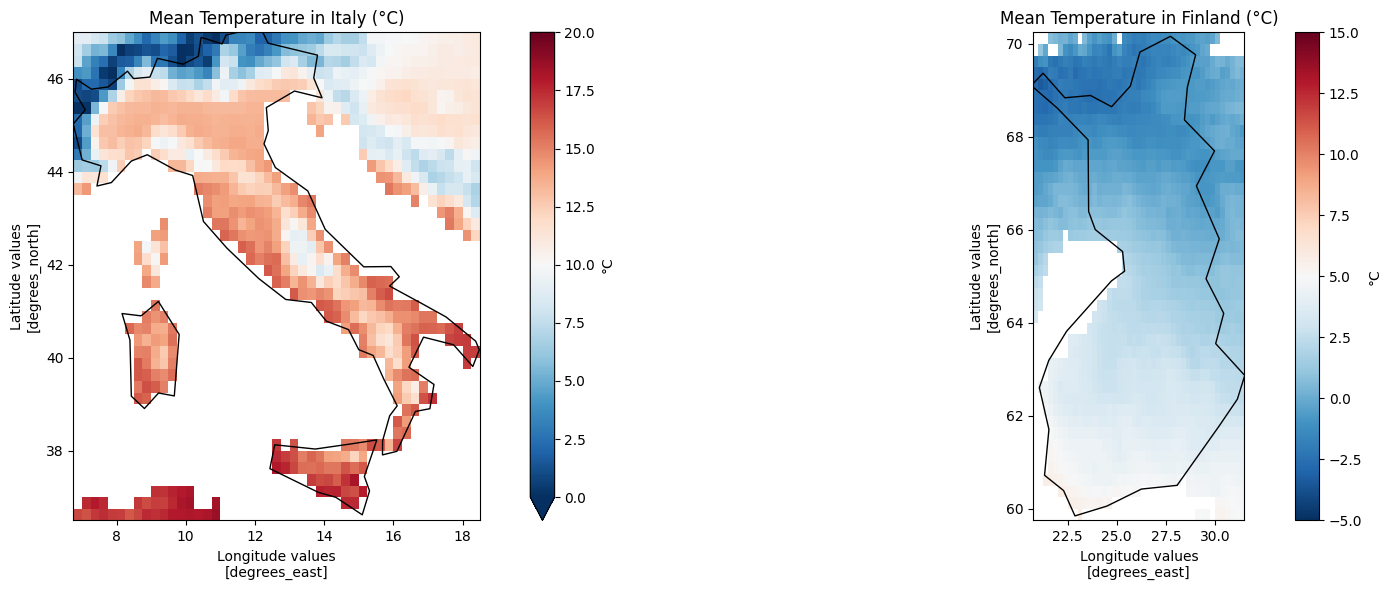

In [47]:
# Calculate annual mean temperatures
italy_annual = italy_data.tg.groupby('time.year').mean()
finland_annual = finland_data.tg.groupby('time.year').mean()

# Create a multi-panel plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Italy mean temperature map
italy_mean = italy_data.tg.mean(dim='time')
im1 = italy_mean.plot(ax=axes[0], cmap='RdBu_r', 
                     vmin=0, vmax=20,
                     cbar_kwargs={'label': '°C'})
axes[0].set_title('Mean Temperature in Italy (°C)')
italy.boundary.plot(ax=axes[0], color='black', linewidth=1)

# Finland mean temperature map
finland_mean = finland_data.tg.mean(dim='time')
im2 = finland_mean.plot(ax=axes[1], cmap='RdBu_r', 
                       vmin=-5, vmax=15,
                       cbar_kwargs={'label': '°C'})
axes[1].set_title('Mean Temperature in Finland (°C)')
finland.boundary.plot(ax=axes[1], color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 7. Time Series Analysis of Temperature Trends

Now let's examine temperature trends over time for both countries.

/var/folders/wn/0_rkm19141n9cjv77jhhbrwc0000gq/T/ipykernel_26504/3209358320.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  italy_annual_df = italy_df.resample('Y').mean()
/var/folders/wn/0_rkm19141n9cjv77jhhbrwc0000gq/T/ipykernel_26504/3209358320.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  finland_annual_df = finland_df.resample('Y').mean()


Italy temperature trend: 0.21°C per decade
Finland temperature trend: 0.26°C per decade


/var/folders/wn/0_rkm19141n9cjv77jhhbrwc0000gq/T/ipykernel_26504/3209358320.py:35: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(annual_temps.index, p(x), '--', linewidth=1.5)


<Figure size 1400x600 with 0 Axes>

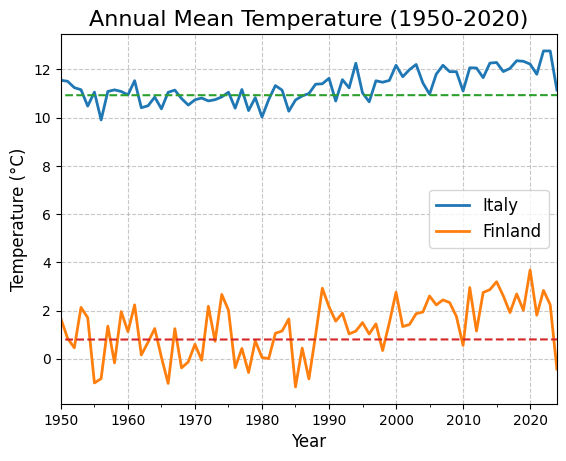

In [48]:
# Calculate spatial means for each time step
italy_timeseries = italy_data.tg.mean(dim=['latitude', 'longitude'])
finland_timeseries = finland_data.tg.mean(dim=['latitude', 'longitude'])

# Convert to pandas for easier handling
italy_df = italy_timeseries.to_dataframe(name='temperature')
finland_df = finland_timeseries.to_dataframe(name='temperature')

# Calculate annual means
italy_annual_df = italy_df.resample('Y').mean()
finland_annual_df = finland_df.resample('Y').mean()

# Combine into one dataframe
annual_temps = pd.DataFrame({
    'Italy': italy_annual_df['temperature'],
    'Finland': finland_annual_df['temperature']
})

# Plot the time series
plt.figure(figsize=(14, 6))
annual_temps.plot(linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Annual Mean Temperature (1950-2020)', fontsize=16)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(fontsize=12)

# Add a trend line
for country in ['Italy', 'Finland']:
    # Calculate linear regression
    x = np.arange(len(annual_temps[country]))
    mask = ~np.isnan(annual_temps[country].values)
    z = np.polyfit(x[mask], annual_temps[country].values[mask], 1)
    p = np.poly1d(z)
    plt.plot(annual_temps.index, p(x), '--', linewidth=1.5)
    
    # Calculate trend magnitude
    trend_per_decade = z[0] * 10  # degrees per decade
    print(f"{country} temperature trend: {trend_per_decade:.2f}°C per decade")

plt.show()